## interplay between nucleosome repair, eviction/redeposition, and transcription
### nicole pagane | roberts lab

In [1]:
import scipy.integrate as snt
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
pass

In [2]:
# declare universal constants
NUC_SPACE = 162
OCT_LEN = 147
HEX_LEN = 107
LOOP_OCT = 100
LOOP_HEX = 71
NUC_MOVE_OCT = 72
NUC_MOVE_HEX = NUC_MOVE_OCT*LOOP_HEX/LOOP_OCT

In [413]:
# initialize system without further knowledge of isw2 and isw1a mechanisms
# this is derived from results of statistical positioning

# intialize gene
def initializeGene(nucLen = OCT_LEN, geneLen = 2000, linker = NUC_SPACE, density = 0.9):
    gene = np.zeros(geneLen)
    # check the density 
    N = int(np.round(density*geneLen/(nucLen + linker)))
    ind = 0
    nucNum = 1
    while ind + nucLen < geneLen and nucNum < N+1:
        gene[ind:ind+nucLen] = nucNum
        spc = linker
        ind = ind + nucLen + spc
        nucNum += 1
    return gene

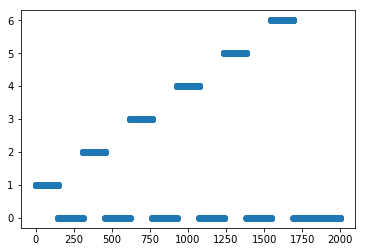

In [414]:
gene = initializeGene()
plt.plot(gene, 'o')
plt.show()

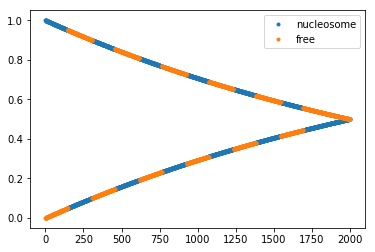

In [415]:
# define gene occupancy expectation
def geneOccupancy(g):
    x = np.linspace(1, len(g), len(g))
    k = -np.log(0.5)
    y = np.exp(-k*x/len(g))
    gScale = np.ceil(g/max(g))*y
    for i in range(len(g)):
        if gScale[i] == 0:
            gScale[i] = 1-y[i]
    return gScale


gRef = geneOccupancy(initializeGene())
plt.plot(gRef, '.', label='nucleosome')
plt.plot(1-gRef, '.', label='free')
plt.legend()
plt.show()

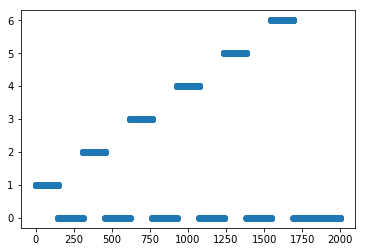

{0.0: 0, 1.0: 163, 2.0: 163, 3.0: 163, 4.0: 163, 5.0: 163, 6.0: 309}


In [416]:
# determine spacing
def detSpace(g):
    gene = np.linspace(0, len(g)-1, len(g))
    space = {}
    nucs = np.unique(g)
    for i in range(len(nucs)):
        lowBound = np.asarray(gene[g==nucs[i-1]], int)
        if nucs[i-1] == 0: lowBound = [0];
        space[nucs[i-1]] = np.asarray(gene[g==nucs[i]], int)[0] - lowBound[-1]
    # append last nuc spacing to end of gene
    space[nucs[-1]] = len(g) - np.asarray(gene[g==nucs[-1]], int)[-1]
    return space

plt.plot(gene, 'o')
plt.show()
print detSpace(gene)

In [543]:
kB = 1.38e-23; T = 295
ecoeff = 7.0/2
kspring = ecoeff*2*kB*T/(NUC_SPACE/3*1e-9)**2

# define energy calculation
def energy(g):
    spc = detSpace(g).values()
    spc = spc[1:len(spc)-1]; spc = np.asarray(spc) # remove the pre +1 linker and remaining space
    en = 0.5*kspring*((NUC_SPACE - spc)/3*1e-9)**2
    k = -np.log(0.5)
    x = np.linspace(0, len(spc), len(spc))
    en *= np.exp(-k*x*1.0/len(spc)) 
    return np.sum(en)

0.2828282828282829


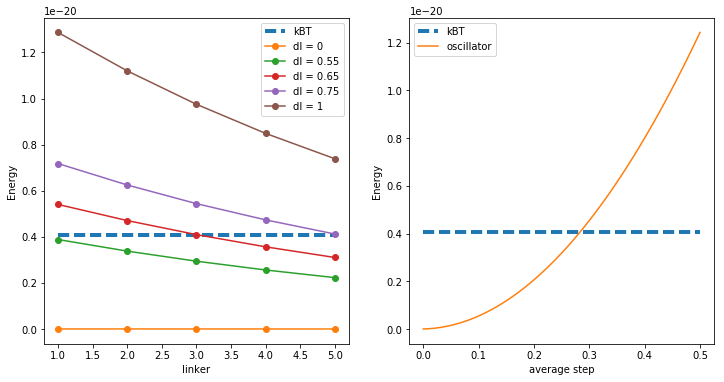

In [750]:
fig = plt.figure(figsize=(12,6))
x = detSpace(initializeGene()).values()
x = x[1:len(x)-1];

k = -np.log(0.5)
y = np.linspace(1, len(x), len(x))

xVec = [1, 1.55, 1.65, 1.75, 2]

ax = fig.add_subplot(1,2,1)
ax.plot(y, np.ones(len(x))*kB*T, '--', label = 'kBT', linewidth = 4)

eSum = []
for i in xVec:
    xnew = i*np.asarray(x) # remove the pre +1 linker and remaining space
    en = 0.5*kspring*((NUC_SPACE - xnew)/3*1e-9)**2
    en *= np.exp(-k*y*1.0/len(x)) 
    ax.plot(y, en, '-o', label = 'dl = ' + str(i-1))
    eSum.append(np.sum(en))
    
ax.set_xlabel('linker'); ax.set_ylabel('Energy')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(xVec2-1, np.ones(len(xVec2))*kB*T, '--', label = 'kBT', linewidth = 4)

xVec2 = np.linspace(1, 1.5, 100)
y = np.linspace(1, len(x), len(x))
eSum = []
for i in xVec2:
    xnew = i*np.asarray(x) # remove the pre +1 linker and remaining space
    en = 0.5*kspring*((NUC_SPACE - xnew)/3*1e-9)**2
    en *= np.exp(-k*y*1.0/len(x)) 
    eSum.append(np.sum(en))

ax.plot(xVec2-1, eSum, label = 'oscillator')
ax.set_xlabel('average step'); ax.set_ylabel('Energy')
ax.legend()

stepSize = xVec2[np.argsort(np.abs(np.asarray(eSum) - kB*T))[0]] - 1
print stepSize 

plt.show()

In [751]:
# MCMC to simulate nucleosome shuffling
def MCMC(g = initializeGene(), N = 1000):
    N = int(N)
    curE = energy(g); lowE = curE
    eVec = []
    propG = np.zeros(len(g))
    gSum = np.ceil(g/max(g))
    gState = np.zeros(len(g)); gState = g[:]*1.0 # shallow copy
    # check that there is more than one nuc left
    if len(set(g)) <= 2:
        return gState, eVec, gSum # quit since dynamics of one nucleosome is not interesting
    ming = np.unique(g)[2] # since 0 = linker, 1 = +1 nuc
    maxg = max(g)+1
    for i in range(N):
        # select random nucleosome
        propNuc = np.random.randint(ming, maxg) 
        propInd = np.array(np.linspace(0, len(g)-1, len(g))[g == propNuc], int) 
        # select random movement
        propMove = int(np.random.normal(0, stepSize*NUC_SPACE)) # sample from normal w spread nuc len
        # implement proposed movement
        move = propInd + propMove
        moveTrim = move[move >= 0]
        move = moveTrim[moveTrim < len(g)]
        # check for collision
        propG = g[:]*1.0 # shallow copy
        propG[propInd] = 0
        if (np.sum(propG[move]) == 0):
            propG[move] = propNuc
            # metropolis criterion
            propE = energy(propG)
            delE = propE - curE
            rand = np.random.rand()
            if (rand < np.exp(-delE/(kB*T))):
                # accept change
                g = propG[:]*1.0 #shallow copy
                curE = propE
            if (i >= 1.0*N/2): # reject the first half off the simulation
                gSum += np.ceil(g/max(g))
                eVec.append(curE)
                # save lowest energy config
                if propE < lowE:
                    gState = g[:]*1.0
                    lowE = propE
    return gState, eVec, gSum

In [764]:
ltest = int(0.75*NUC_SPACE)
dens = 0.75
gene = initializeGene(linker = ltest, density = dens)

n1 = 500; n2 = 1000; n3 = 5000

gene1, eVec1, gA1= MCMC(gene, n1)
gene2, eVec2, gA2 = MCMC(gene, n2)
gene3, eVec3, gA3 = MCMC(gene, n3)

allowed moves for 1: 233
allowed moves for 2: 490
allowed moves for 3: 2263


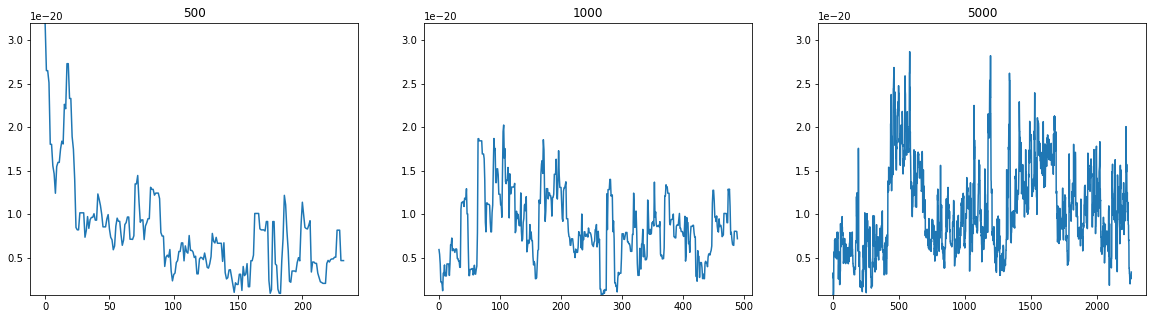

In [765]:
print 'allowed moves for 1: ' + str(len(eVec1))
print 'allowed moves for 2: ' + str(len(eVec2))
print 'allowed moves for 3: ' + str(len(eVec3))

totE = []; totE.extend(eVec1); totE.extend(eVec2); totE.extend(eVec3)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n1)
ax.plot(eVec1)
ax = fig.add_subplot(1,3,2)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n2)
ax.plot(eVec2)
ax = fig.add_subplot(1,3,3)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n3)
ax.plot(eVec3)

plt.show()

intial energy  3.0080193121974586e-21


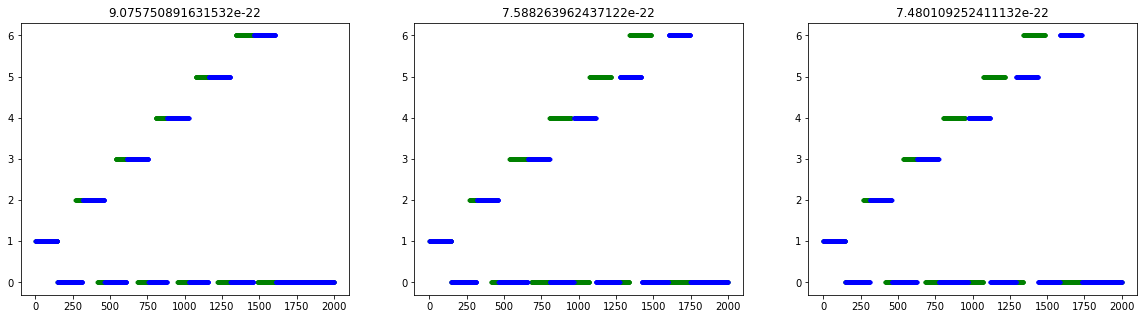

In [766]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gene, 'g.')
ax.plot(gene1, 'b.')
ax.set_title(energy(gene1))
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gene, 'g.')
ax.plot(gene2, 'b.')
ax.set_title(energy(gene2))
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gene, 'g.')
ax.plot(gene3, 'b.')
ax.set_title(energy(gene3))

print 'intial energy ', energy(gene)

plt.show()

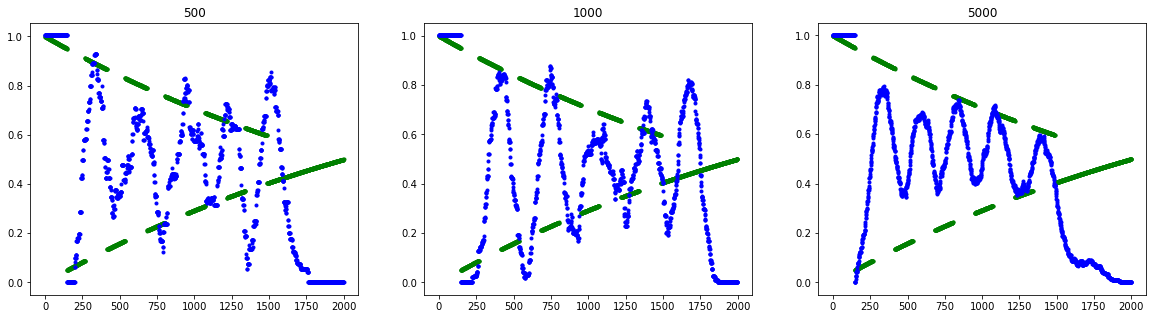

In [767]:
# reference
gRef = geneOccupancy(initializeGene(linker = ltest, density = dens))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gRef, 'g.')
ax.plot(gA1/len(eVec1), 'b.')
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gRef, 'g.')
ax.plot(gA2/len(eVec2), 'b.')
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gRef, 'g.')
ax.plot(gA3/len(eVec3), 'b.')

plt.show()

### add transcription

In [720]:
# probs from paper 
kue = 1; N = 40; Nt = 147; kt = 0.02; kd = 0.027
phex = (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N)) - (kue/(kt+kue))**Nt
poct = 1.0 - (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N))
pfree = (kue/(kt+kue))**Nt

print 'prob of hex: ', phex*100 
print 'prob of oct: ', poct*100
print 'prob of free: ', pfree*100

prob of hex:  20.7163647036
prob of oct:  73.8414321259
prob of free:  5.44220317046


In [997]:
# define RNAP passage effects
def RNAP(g):
    # check that there is more than one nuc left
    if len(set(g)) <= 2:
        return g # quit since dynamics of one nucleosome is not interesting
    temp = np.zeros(len(g))
    spc = detSpace(g)
    nucs = spc.keys()
    # attempt +1 nuc alteration (without upstream move)
    nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[1]], int)
    #temp = g[:]*1.0
    if (np.sum(1 == g) == OCT_LEN):
        # randomly determine fate of octomer from above probabilities
        rand = np.random.random()
        if rand < pfree: # remove octomer
            temp[nuc] = 0
        elif rand < (pfree+phex): # lose dimer and move upstream
            temp[nuc] = 0
            # shave off sides
            side = (OCT_LEN-HEX_LEN)/2
            nuc = np.linspace(min(nuc)+side, max(nuc)-side, HEX_LEN, dtype = int)
            temp[nuc] = int(nucs[1])
    elif (np.sum(1 == g) == HEX_LEN):
        # randomly determine fate of octomer from above probabilities
        rand = np.random.random()
        if rand < pfree/(pfree+phex): # remove hexasome (reweighted probs)
            temp[nuc] = 0
    # attempt movement on the rest of the nucleosomes
    #g = temp[:]*1.0 DONT ACCEPT +1 CHANGES YET
    i = 1
    while (i < len(spc)-1):
        #temp = g[:]*1.0
        nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[i+1]], int)
        dist = spc
        if (spc[nucs[i]] >= LOOP_OCT and np.sum(nucs[i+1] == g) == OCT_LEN): # octosome
            # randomly determine fate of octomer from above probabilities
            rand = np.random.random()
            if rand < pfree: # remove octomer
                g[nuc] = 0 #temp[nuc] = 0
            elif rand < (pfree+phex): # lose dimer and move upstream
                g[nuc] = 0 #temp[nuc] = 0
                # shave off sides
                side = (OCT_LEN-HEX_LEN)/2
                nuc = np.linspace(min(nuc)+side, max(nuc)-side, HEX_LEN, dtype = int)
                g[nuc - NUC_MOVE_HEX] = int(nucs[i+1]) #temp[nuc - NUC_MOVE_HEX] = int(nucs[i+1])
            else: # move upstream as octomer
                g[nuc] = 0 #temp[nuc] = 0
                g[nuc - NUC_MOVE_OCT] = int(nucs[i+1])#temp[nuc - NUC_MOVE_OCT] = g[nuc]
        elif (spc[nucs[i]] >= LOOP_HEX and np.sum(nucs[i+1] == g) == HEX_LEN): # hexasome
             # randomly determine fate of octomer from above probabilities
                rand = np.random.random()
                if rand < pfree/(pfree+phex): # remove hexasome (reweighted probs)
                    g[nuc] = 0 #temp[nuc] = 0
                else: # move hexasome
                    g[nuc] = 0 #temp[nuc] = 0
                    g[nuc - NUC_MOVE_HEX] = int(nucs[i+1]) #temp[nuc - NUC_MOVE_HEX] = g[nuc]
        else: # remove nucleosome due to crowding or make hexasome
            g[nuc] = 0 #temp[nuc] = 0
        #g = temp[:]*1.0
        i += 1
        spc = detSpace(g)
        nucs = spc.keys()
    return g

In [999]:
cycles = 10
gene = []
en = []
g = initializeGene();
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    if gempty == len(g) or gempty == (len(g) - OCT_LEN) or gempty == (len(g) - HEX_LEN):
        print 'terminated early since only one left'
        break
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    print 'transcription ', i+1, ': ', detSpace(g).values()
    g, e, gA = MCMC(g, 1000)
    gene.append(g); en.extend(e); gAv.append(gA/len(e))
    print 'relaxation ', i+1, ': ', detSpace(g).values()

transcription  1 :  [0, 472, 91, 163, 163, 381]
relaxation  1 :  [0, 155, 165, 133, 149, 668]
transcription  2 :  [0, 83, 516, 77, 740]
relaxation  2 :  [0, 167, 166, 171, 912]
transcription  3 :  [0, 95, 166, 171, 984]
relaxation  3 :  [0, 180, 152, 157, 927]
transcription  4 :  [0, 108, 152, 157, 999]
relaxation  4 :  [0, 163, 151, 158, 944]
transcription  5 :  [0, 132, 150, 158, 1016]
relaxation  5 :  [0, 171, 159, 142, 984]
transcription  6 :  [0, 120, 138, 142, 1056]
relaxation  6 :  [0, 184, 168, 164, 940]
transcription  7 :  [0, 133, 147, 164, 1012]
relaxation  7 :  [0, 133, 147, 164, 1012]
transcription  8 :  [0, 82, 126, 205, 1083]
relaxation  8 :  [0, 166, 176, 181, 973]
transcription  9 :  [0, 115, 155, 202, 1024]
relaxation  9 :  [0, 157, 156, 156, 1027]
transcription  10 :  [0, 106, 176, 1360]
relaxation  10 :  [0, 165, 158, 1319]


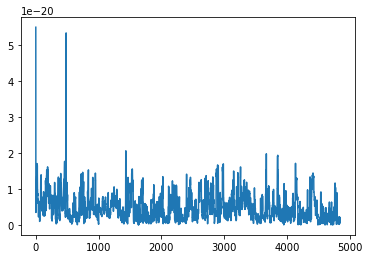

In [1000]:
plt.plot(en)
plt.show()

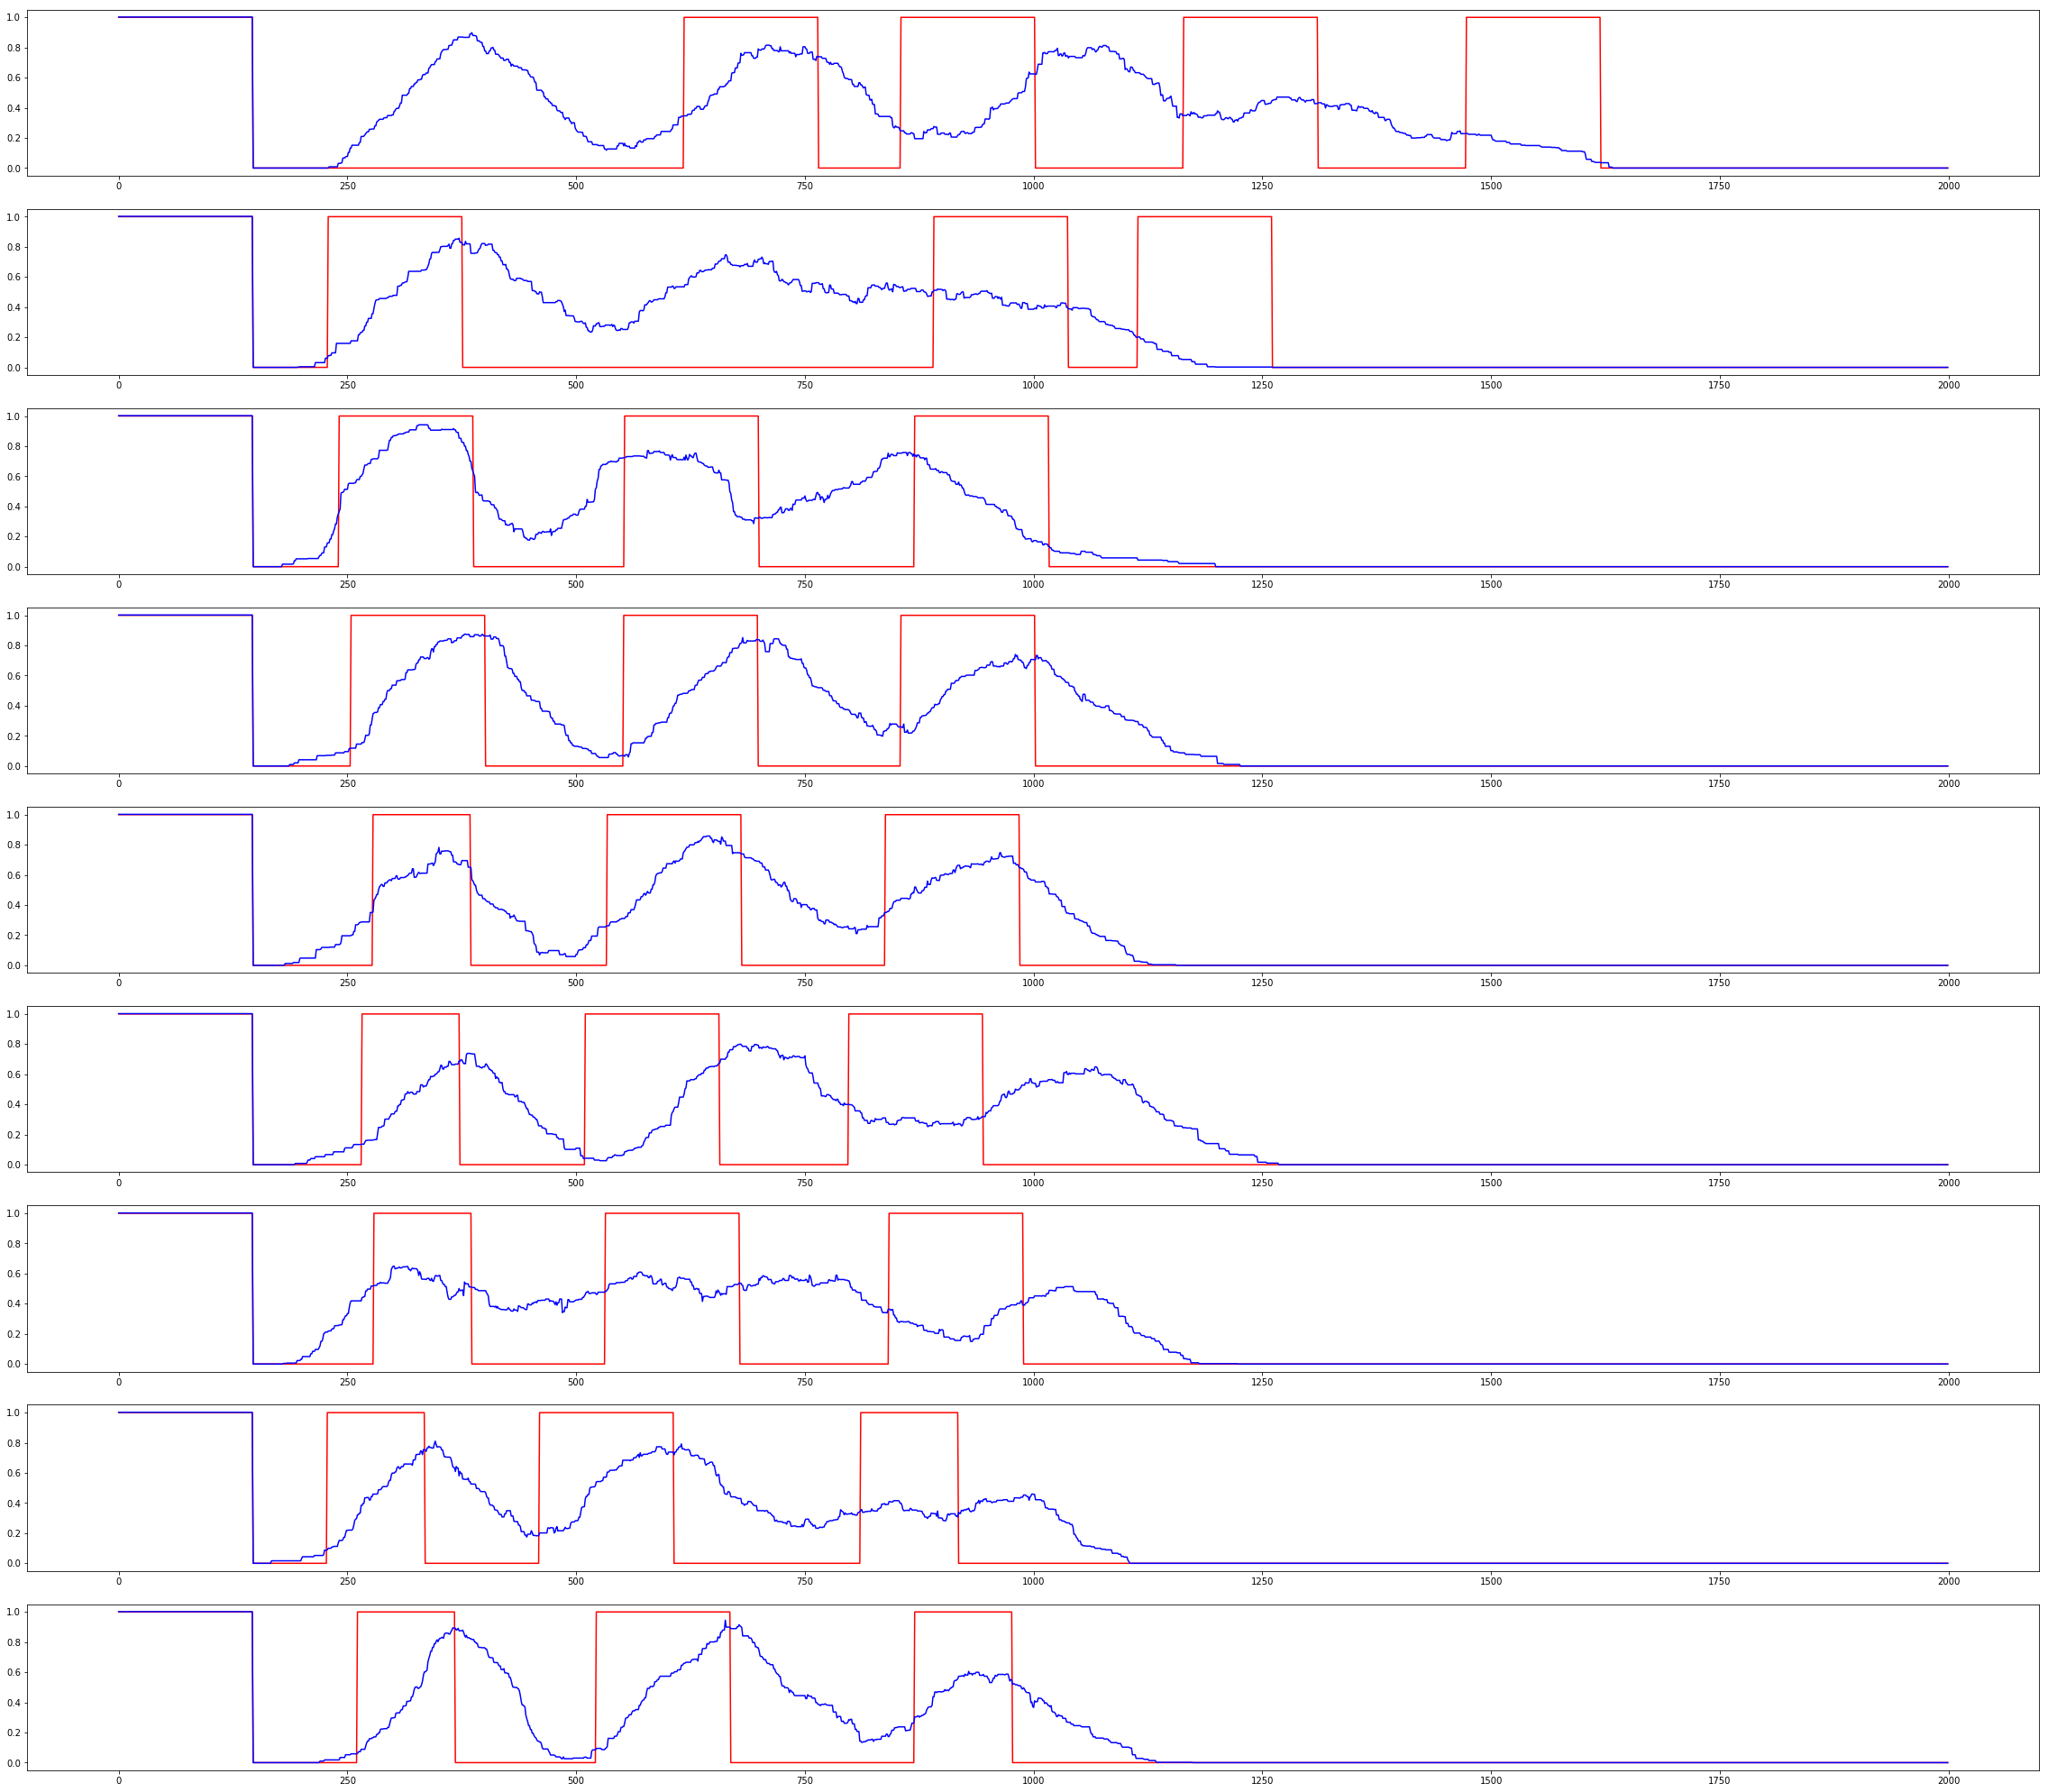

In [1001]:
fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*i:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

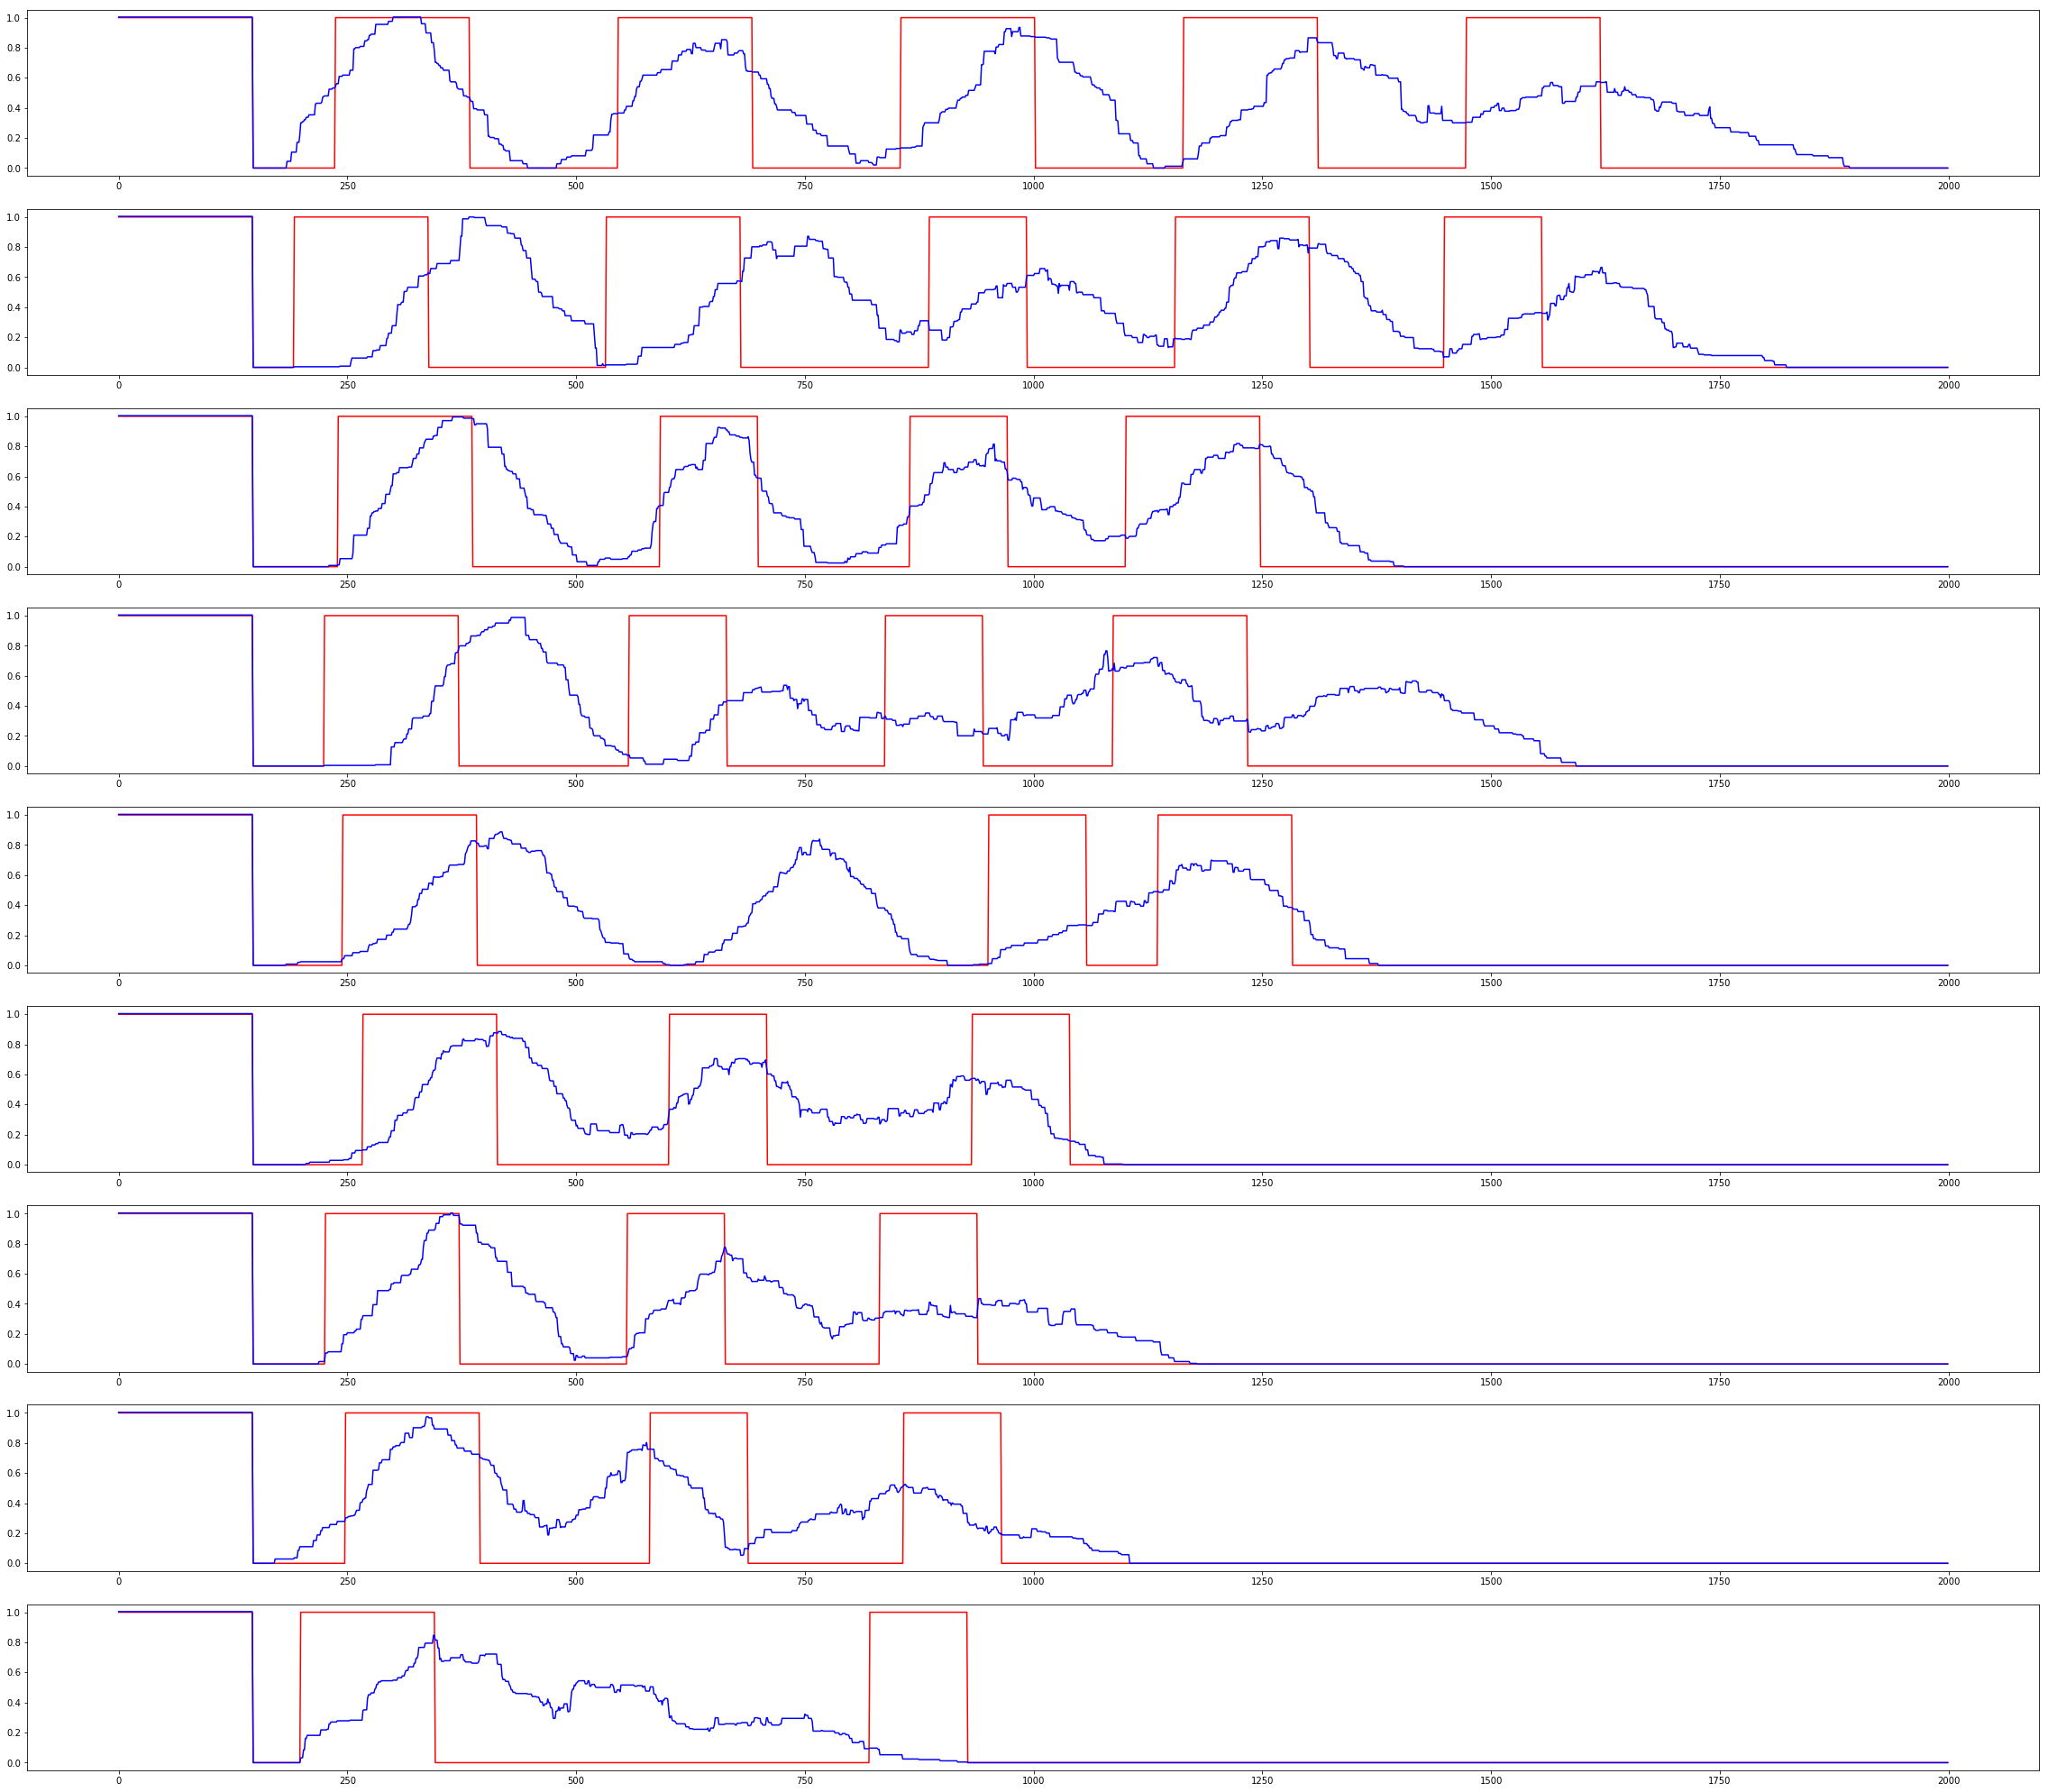

In [1006]:
cycles = 10
gene = []
en = []
g = initializeGene(); gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    if gempty == len(g) or gempty == (len(g) - OCT_LEN) or gempty == (len(g) - HEX_LEN):
        print 'terminated at', i, 'since only one left'
        break
    gene.append(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 500)
    gene.append(g); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*i:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

In [731]:
# run several simulations varying transcription rate to gather statistics
runs = {}
cycles = 5
reps = 10
geneLen = 2000
pts = 10
minFreq = 250
maxFreq = 2500

for trate in np.linspace(minFreq,maxFreq,pts):
    gene = np.zeros(geneLen); en = [];
    for rep in range(reps):
        en = []
        g = initializeGene()
        for i in range(cycles):
            g = RNAP(g);
            gempty = np.sum(g == 0)
            if gempty == len(g) or gempty == (len(g) - OCT_LEN) or gempty == (len(g) - HEX_LEN):
                break
            en.append(energy(g));
            g, e, gA = MCMC(g, int(trate));
            if gempty == len(g) or gempty == (len(g) - OCT_LEN) or gempty == (len(g) - HEX_LEN):
                break
            en.extend(e); 
        gene += np.ceil(g/max(g))/reps; minE = min(en); avgE = np.mean(en)
    runs[int(trate)] = [gene, minE, avgE]
    print reps, ' sims for MCMC iter ', int(trate), ' done'
print 'done'

10  sims for MCMC iter  250  done
10  sims for MCMC iter  500  done
10  sims for MCMC iter  750  done
10  sims for MCMC iter  1000  done
10  sims for MCMC iter  1250  done
10  sims for MCMC iter  1500  done
10  sims for MCMC iter  1750  done
10  sims for MCMC iter  2000  done
10  sims for MCMC iter  2250  done
10  sims for MCMC iter  2500  done
done


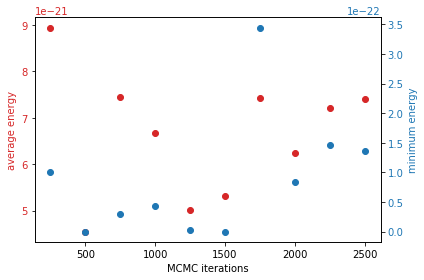

In [878]:
# plot energy
aen = []
men = []
trate = []
count = 0
for i in runs.keys():
    trate.append(i)
    aen.append(runs[i][2])
    men.append(runs[i][1])
    
order = np.argsort(trate)
trate = np.asarray(trate)[order]; men = np.asarray(men)[order]; aen = np.asarray(aen)[order]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('MCMC iterations')
ax1.set_ylabel('average energy', color=color)
ax1.plot(trate, aen, 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('minimum energy', color=color)  # we already handled the x-label with ax1
ax2.plot(trate, men, 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

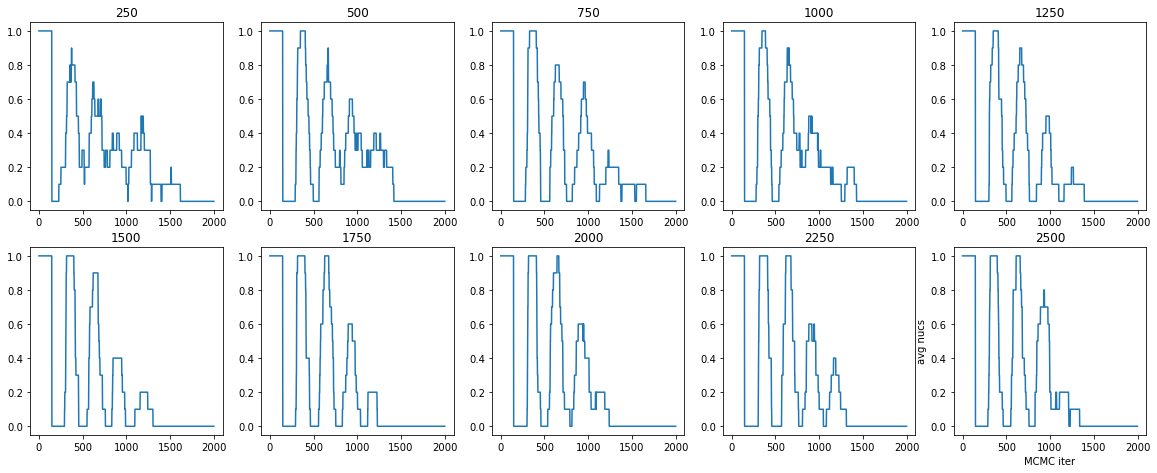

In [735]:
fig = plt.figure(figsize = (20,20))

pltInd = 0
keys = np.sort(runs.keys())
for i in keys:
    ax = fig.add_subplot(np.ceil(pts/2),np.floor(pts/2),pltInd+1)
    ax.plot(runs[i][0], '-')
    ax.set_title(i)
    pltInd += 1
    
plt.xlabel('MCMC iter'); plt.ylabel('avg nucs')
plt.show()

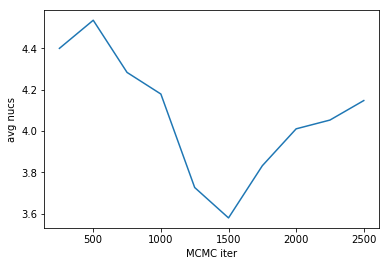

In [738]:
keys = np.sort(runs.keys())
y = []
for i in keys:
    y.append(np.sum(runs[i][0])/(0.5*(HEX_LEN+OCT_LEN)))
    
plt.plot(keys,y)
plt.xlabel('MCMC iter'); plt.ylabel('avg nucs')
plt.show()

### dimer replacement

In [966]:
def repair(g, prep):
    spc = detSpace(g)
    nucs = spc.keys(); nucs = np.asarray(nucs, int)
    hexes = []
    #temp = np.zeros(len(g))
    for i in range(2, len(nucs)):
        #temp = g[:]*1.0
        nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[i]], int)
        if (len(nuc) == HEX_LEN): # ensure that a hexasome is selected for
            rand = np.random.rand()
            if rand < prep and spc[nucs[i]] > (OCT_LEN-HEX_LEN)/2 and spc[nucs[i-1]] > (OCT_LEN-HEX_LEN)/2:
                # repair nuc
                g[nuc] = 0 #temp[nuc] = 0
                # add nuc sides
                side = (OCT_LEN-HEX_LEN)/2
                nuc = np.linspace(min(nuc)-side, max(nuc)+side, OCT_LEN, dtype = int)
                g[nuc] = i
        #g = temp[:]*1.0
        spc = detSpace(g)
    return g

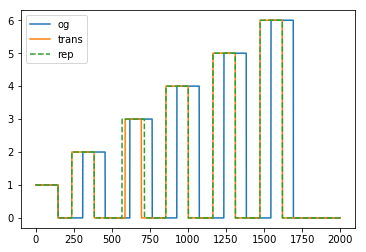

In [968]:
g = initializeGene()
plt.plot(g, label = 'og')
g = RNAP(g)
plt.plot(g, label = 'trans')
#g, e, ga = MCMC(g, 500)
g = repair(g, 1.0)
#g, e, ga = MCMC(g, 500)
plt.plot(g, '--', label = 'rep')

plt.legend()
plt.show()

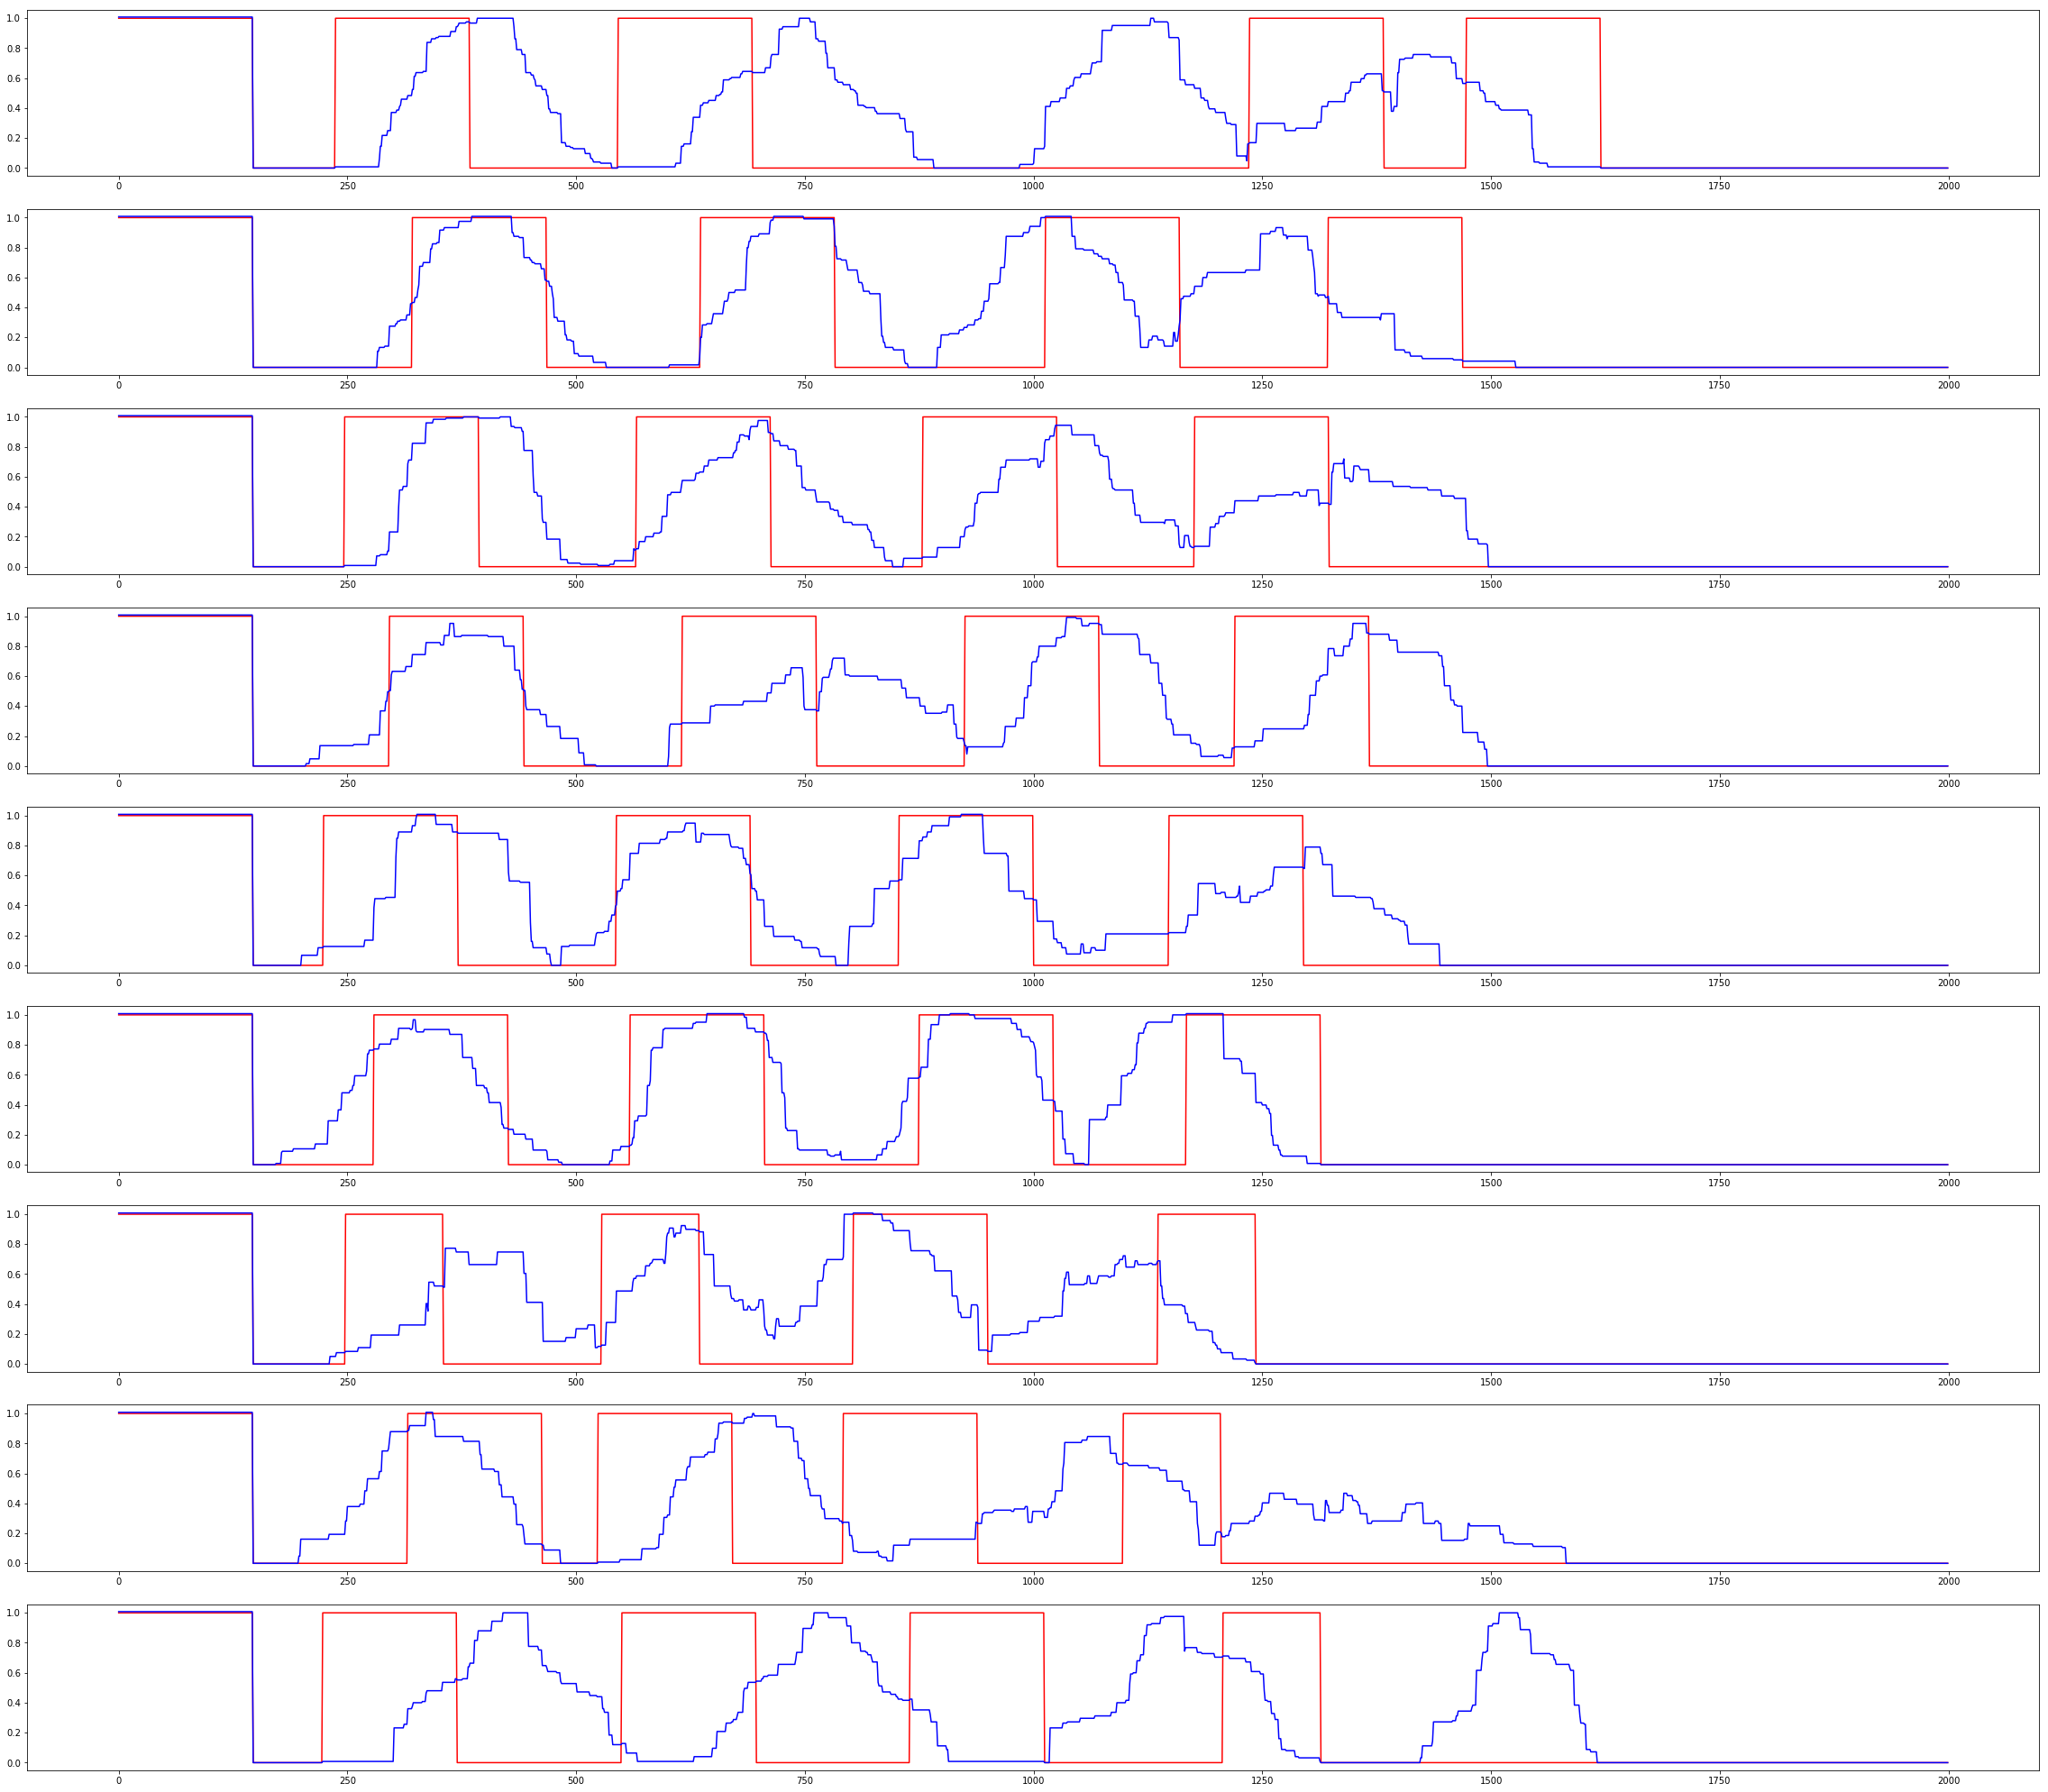

In [1021]:
cycles = 10
gene = []
en = []
g = initializeGene()
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    if gempty == len(g) or gempty == (len(g) - OCT_LEN) or gempty == (len(g) - HEX_LEN):
        print 'terminated at', i, ' since only one left'
        break
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 250); en.extend(e); gAv.append(gA/len(e))
    g = repair(g, 0.5); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 250); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*i:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()